# Self made SVD

In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [4]:
# Done similarly to https://github.com/albertauyeung/matrix-factorization-in-python
from tqdm import tqdm

class SVD():
    
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui=train_ui
        self.uir=list(zip(*[train_ui.nonzero()[0],train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate=learning_rate
        self.regularization=regularization
        self.iterations=iterations
        self.nb_users, self.nb_items=train_ui.shape
        self.nb_ratings=train_ui.nnz
        self.nb_factors=nb_factors
        
        self.Pu=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_users, self.nb_factors))
        self.Qi=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_items, self.nb_factors))

    def train(self, test_ui=None):
        if test_ui!=None:
            self.test_uir=list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process=[]
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui==None:
                self.learning_process.append([i+1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i+1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    def sgd(self, uir):
        
        for u, i, score in uir:
            # Computer prediction and error
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            # Update user and item latent feature matrices
            Pu_update=self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update=self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
        
    def get_rating(self, u, i):
        prediction = self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    def RMSE_total(self, uir):
        RMSE=0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE+=(score - prediction)**2
        return np.sqrt(RMSE/len(uir))
    
    def estimations(self):
        self.estimations=\
        np.dot(self.Pu,self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [12]:
model=SVD(train_ui, learning_rate=0.005, regularization=0.02, nb_factors=100, iterations=40)
model.train(test_ui)

Epoch 39 RMSE: 0.7493723517098142. Training epoch 40...: 100%|██████████| 40/40 [02:06<00:00,  3.16s/it]


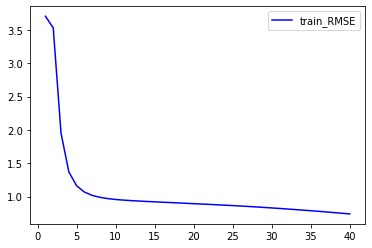

In [15]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process).iloc[:,:2]
df.columns=['epoch', 'train_RMSE']
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.legend()

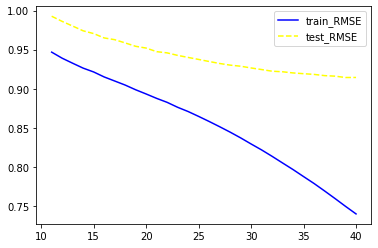

In [16]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process[10:], columns=['epoch', 'train_RMSE', 'test_RMSE'])
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.plot('epoch', 'test_RMSE', data=df, color='yellow', linestyle='dashed')
plt.legend()

#### Saving and evaluating recommendations

In [17]:
model.estimations()

top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_SVD_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', index=False, header=False)

In [18]:
import evaluation_measures as ev

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_SVD_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 4912.25it/s]


RMSE       MAE  precision    recall      F_1      F_05  precision_super  \
0  0.9144  0.718047   0.103393  0.043404  0.05292  0.070119         0.093455   

   recall_super      NDCG      mAP       MRR      LAUC      HR  Reco in test  \
0      0.074901  0.107441  0.05077  0.200719  0.518433  0.4772      0.866384   

   Test coverage   Shannon      Gini  
0       0.145743  3.860721  0.972299

In [37]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 4816.30it/s]
943it [00:00, 4733.95it/s]
943it [00:00, 4623.19it/s]
943it [00:00, 5099.59it/s]
943it [00:00, 4968.40it/s]
943it [00:00, 5056.01it/s]
943it [00:00, 5009.35it/s]
943it [00:00, 3610.70it/s]
943it [00:00, 4280.45it/s]
943it [00:00, 4473.91it/s]
943it [00:00, 4438.83it/s]
943it [00:00, 5165.96it/s]
943it [00:00, 5259.28it/s]
943it [00:00, 4607.07it/s]
943it [00:00, 4329.45it/s]
943it [00:00, 4693.81it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0         Self_RP3Beta  3.702446  3.527273   0.282185  0.192092  0.186749   
0          Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0            Ready_SVD  0.952784  0.750597   0.095228  0.047497  0.053142   
0     Self_SVDBaseline  0.913380  0.719974   0.105726  0.045055  0.054233   
0             Self_SVD  0.914400  0.718047   0.103393  0.043404  0.052920   
0      Ready_SVDBiased  0.940375  0.742264   0.092153  0.039645  0.046804   
0       Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0       Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0         Ready_Random  1.518551  1.218784   0.050583  0.024085  0.027323   
0          Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0  Ready_U-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0  Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0          Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0        Self_TopRated  1.033085  0.822057   0.000954  0.000188  0.000298   
0      Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0            Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.216980         0.204185      0.240096  0.339114  0.204905  0.572157   
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.067082         0.084871      0.076457  0.109075  0.050124  0.241366   
0  0.071579         0.096674      0.075899  0.119979  0.059709  0.251389   
0  0.070119         0.093455      0.074901  0.107441  0.050770  0.200719   
0  0.061886         0.079399      0.055967  0.102017  0.047972  0.216876   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.034826         0.031223      0.026436  0.054902  0.020652  0.137928   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR  Reco in test  Test coverage   Shannon      Gini  
0  0.593544  0.875928      1.000000       0.077201  3.875892  0.974947  
0  0.555546  0.765642      1.000000       0.038961  3.159079  0.987317  
0  0.520459  0.499470      0.992047       0.217893  4.405246  0.953484  
0  0.519270  0.476140      0.999788       0.115440  3.578129  0.980463  
0  0.518433  0.477200      0.866384       0.145743  3.860721  0.972299  
0  0.516515  0.441145      0.997455       0.167388  4.235348  0.962085  
0  0.515501  0.437964      1.000000       0.033911  2.836513  0.991139  
0  0.509546  0.384942      1.000000       0.025974  2.711772  0.992003  
0  0.508570  0.353128      0.987699       0.183261  5.093805  0.908215  
0  0.499885  0.154825      0.402333       0.434343  5.133650  0.877999  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496441  0.007423      0.602121       0.010823  2.089186  0.995706  
0  0.496433  0.009544      0.699046       0.005051  1.945910  0.995669  
0  0.496424  0.009544      0.600530       0.005051  1.803126  0.996380  
0  0.496391  0.003181      0.392153       0.115440  4.174741  0.965327

### Embeddings

In [24]:
x=np.array([[1,2],[3,4]])
display(x)
x/np.linalg.norm(x, axis=1)[:,None]

array([[1, 2],
       [3, 4]])

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

In [33]:
item=random.choice(list(set(train_ui.indices)))

embeddings_norm=model.Qi/np.linalg.norm(model.Qi, axis=1)[:,None] # we do not mean-center here
# omitting normalization also makes sense, but items with a greater magnitude will be recommended more often

similarity_scores=np.dot(embeddings_norm,embeddings_norm[item].T)
top_similar_items=pd.DataFrame(enumerate(similarity_scores), columns=['code', 'score'])\
.sort_values(by=['score'], ascending=[False])[:10]

top_similar_items['item_id']=top_similar_items['code'].apply(lambda x: item_code_id[x])

items=pd.read_csv('./Datasets/ml-100k/movies.csv')

result=pd.merge(top_similar_items, items, left_on='item_id', right_on='id')

result

code     score  item_id    id                             title  \
0   257  1.000000      258   258                    Contact (1997)   
1   221  0.739090      222   222   Star Trek: First Contact (1996)   
2    63  0.736794       64    64  Shawshank Redemption, The (1994)   
3  1162  0.736777     1163  1163    Portrait of a Lady, The (1996)   
4   125  0.736246      126   126        Spitfire Grill, The (1996)   
5   309  0.734523      310   310             Rainmaker, The (1997)   
6  1605  0.733826     1606  1606                   Deceiver (1997)   
7   238  0.731338      239   239                   Sneakers (1992)   
8   222  0.724939      223   223                Sling Blade (1996)   
9   266  0.724812      267   267                           unknown   

                      genres  
0              Drama, Sci-Fi  
1  Action, Adventure, Sci-Fi  
2                      Drama  
3                      Drama  
4                      Drama  
5                      Drama  
6                      Crime  
7       Crime, Drama, Sci-Fi  
8            Drama, Thriller  
9                    unknown

# project task 5:  implement SVD on top baseline (as it is in Surprise library)

In [34]:
# making changes to our implementation by considering additional parameters in the gradient descent procedure 
# seems to be the fastest option
# please save the output in 'Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv' and
# 'Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv'

# Ready-made SVD - Surprise implementation

### SVD

In [39]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD(biased=False) # to use unbiased version

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVD_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVD_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


### SVD biased - on top baseline

In [4]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD() # default is biased=True

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVDBiased_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVDBiased_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


In [40]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 4850.60it/s]
943it [00:00, 4963.77it/s]
943it [00:00, 4500.32it/s]
943it [00:00, 5033.32it/s]
943it [00:00, 4491.41it/s]
943it [00:00, 5213.78it/s]
943it [00:00, 4930.11it/s]
943it [00:00, 4835.44it/s]
943it [00:00, 4567.62it/s]
943it [00:00, 4836.97it/s]
943it [00:00, 3965.34it/s]
943it [00:00, 4790.98it/s]
943it [00:00, 4721.85it/s]
943it [00:00, 4756.99it/s]
943it [00:00, 5004.97it/s]
943it [00:00, 4844.54it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0         Self_RP3Beta  3.702446  3.527273   0.282185  0.192092  0.186749   
0          Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0            Ready_SVD  0.951985  0.749904   0.105832  0.054287  0.059099   
0     Self_SVDBaseline  0.913380  0.719974   0.105726  0.045055  0.054233   
0             Self_SVD  0.914400  0.718047   0.103393  0.043404  0.052920   
0      Ready_SVDBiased  0.940375  0.742264   0.092153  0.039645  0.046804   
0       Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0       Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0         Ready_Random  1.518551  1.218784   0.050583  0.024085  0.027323   
0          Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0  Ready_U-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0  Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0          Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0        Self_TopRated  1.033085  0.822057   0.000954  0.000188  0.000298   
0      Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0            Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.216980         0.204185      0.240096  0.339114  0.204905  0.572157   
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.074448         0.093562      0.085108  0.124663  0.060089  0.275660   
0  0.071579         0.096674      0.075899  0.119979  0.059709  0.251389   
0  0.070119         0.093455      0.074901  0.107441  0.050770  0.200719   
0  0.061886         0.079399      0.055967  0.102017  0.047972  0.216876   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.034826         0.031223      0.026436  0.054902  0.020652  0.137928   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR  Reco in test  Test coverage   Shannon      Gini  
0  0.593544  0.875928      1.000000       0.077201  3.875892  0.974947  
0  0.555546  0.765642      1.000000       0.038961  3.159079  0.987317  
0  0.523903  0.527041      0.999682       0.214286  4.410890  0.953748  
0  0.519270  0.476140      0.999788       0.115440  3.578129  0.980463  
0  0.518433  0.477200      0.866384       0.145743  3.860721  0.972299  
0  0.516515  0.441145      0.997455       0.167388  4.235348  0.962085  
0  0.515501  0.437964      1.000000       0.033911  2.836513  0.991139  
0  0.509546  0.384942      1.000000       0.025974  2.711772  0.992003  
0  0.508570  0.353128      0.987699       0.183261  5.093805  0.908215  
0  0.499885  0.154825      0.402333       0.434343  5.133650  0.877999  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496441  0.007423      0.602121       0.010823  2.089186  0.995706  
0  0.496433  0.009544      0.699046       0.005051  1.945910  0.995669  
0  0.496424  0.009544      0.600530       0.005051  1.803126  0.996380  
0  0.496391  0.003181      0.392153       0.115440  4.174741  0.965327